In [9]:
import sys
import os
import json
import networkx as nx

# Since we are in a sub-package, ensure that the top-level package is on the Python path
sys.path.append(os.path.abspath(os.path.join('..', '..')))

# Now we can import modules from python_fbas
from python_fbas.fbas_graph import FBASGraph
from python_fbas.fbas_graph_analysis import top_tier as get_top_tier, is_overlay_resilient, num_not_blocked
from python_fbas.constellation.constellation import *

# %load_ext line_profiler

# Evaluating Constellation on a Stellar-network snapshot of January 3rd, 2025

We start by examining the Stellar network as it was on January 3rd, 2025.
* `data/network-2025-01-03.json` contains the quorum-set configuration of the validators.
* `data/survey-2025-01-03.json` is the result of the overlay survey that ran on that day.


First we compute the top-tier of the network (the top-tier is defined as the union of all minimal quorums):

In [10]:
json_data = json.load(open('data/network-2025-01-03.json'))
fbas = FBASGraph.from_json(json_data, from_stellarbeat=True)
top_tier = get_top_tier(fbas)
top_tier_fbas:FBASGraph = fbas.project(top_tier)
top_tier_orgs = [top_tier_fbas.vertice_attrs(v)['homeDomain'] for v in top_tier_fbas.validators]
print(f"The top-tier has {len(top_tier_fbas.validators)} validators and {len(set(top_tier_orgs))} unique organizations: {set(top_tier_orgs)}")

The top-tier has 23 validators and 7 unique organizations: {'publicnode.org', 'lobstr.co', 'whalestack.com', 'satoshipay.io', 'www.franklintempleton.com', 'www.stellar.org', 'stellar.blockdaemon.com'}


Next we check whether the overlay graph obtained by Stellar's network survey is FBA-resilient. This means checking that, for every minimal quorum Q, if we remove the complement of Q from the communication graph, the communication graph remains connected. We can check this with the help of a SAT solver using `fbas_graph_analysis.is_overlay_resilient`. However this check is too expensive for our simulations.

Instead we check that, for every node n, for every set S that suffices to satisfy the agreement requirements of n, n has at least one overlay connection to a member of S. If this does not hold, then the overlay is clearly not FBA-resilient. So this (pseudo-)resilience test has false-positives (FBAS that pass the test but that are not resilient). Nevertheless it seems to provide good estimates when we compare it to the SAT-based check.

In [11]:
overlay:nx.Graph = load_survey_graph('data/survey-2025-01-03.json')
# restrict the overlay to the top-tier validators:
top_tier_overlay:nx.Graph = overlay.subgraph(top_tier)
# average degree of the top-tier in the full overlay:
degrees = [overlay.degree(n) for n in top_tier]
avg_degree = sum(degrees) / len(degrees)
print(f"average degree of the top-tier nodes in full overlay: {avg_degree}")
# compute the average degree of the top-tier overlay:
degrees = [top_tier_overlay.degree(n) for n in top_tier_overlay.nodes]
avg_degree = sum(degrees) / len(degrees)
print(f"average degree of the top-tier overlay: {avg_degree}")
print(f"Among the top-tier, {num_not_blocked(top_tier_fbas, top_tier_overlay)}/{len(top_tier_fbas.validators)} validators do not have their connectivity requirements met")


average degree of the top-tier nodes in full overlay: 45.47826086956522
average degree of the top-tier overlay: 4.260869565217392
Among the top-tier, 23/23 validators do not have their connectivity requirements met


We can also check using the SAT-based check that the top-tier overlay is not FBAS-resilient:

In [12]:
print(is_overlay_resilient(top_tier_fbas, top_tier_overlay))

False


Next we evaluate using a random overlay for the top-tier fbas.
We estimate the smallest value of p such that, with high probability, an Erdos-Renyi graph on n nodes with edge probability p is FBAS-resilient. For performance reasons, as described above, we only check that, for every quorum Q, every member of Q has a peer in Q (which does not guarantee connectivity). This means that we obtain an upper bound on p. For this, we sample a random graphs for a range of expected degrees and compute the smallest expected degree for which 99% of the samples pass the test.

In [ ]:
nodes = list(top_tier_fbas.validators)
min_d = 16
max_d = 20
num_samples = 500
num_sat = {} # dict holding the results
# loop over all value of the degree d from min_d to max_d:
for d in range(min_d, max_d+1):
    num_sat[d] = 0
    for i in range(num_samples):
        # Create an Erdos-Renyi graph with expected degree d:
        g = nx.erdos_renyi_graph(len(nodes), d / len(nodes))
        # rename the nodes to the validator names:
        g = nx.relabel_nodes(g, {i: nodes[i] for i in range(len(nodes))})
        # we could use the SAT-based check, but it's too expensive:
        # if is_overlay_resilient(top_tier_fbas, g):
        if num_not_blocked(top_tier_fbas, g) == 0:
            num_sat[d] += 1
            
# Next we find the minimum degree d for which the probability of the assumptions being satisfied is 0.99:
while num_sat[min_d] / num_samples < 0.99:
    min_d += 1
print(f'For an expected degree of {min_d}, the probability of the assumptions being satisfied is at least 0.99.')

For an expected degree of 18, the probability of the assumptions being satisfied is at least 0.99.


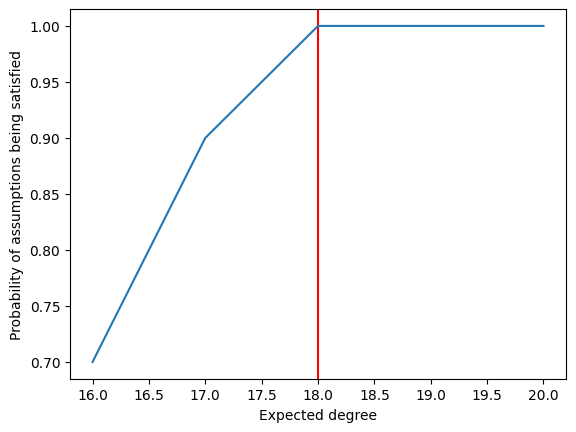

In [14]:
# now plot the results
import matplotlib.pyplot as plt
plt.axvline(x=min_d, color='r')
plt.xlabel('Expected degree')
plt.ylabel('Probability of assumptions being satisfied')
plt.plot(num_sat.keys(), [v/num_samples for v in num_sat.values()])

The results above indicate that, to obtain an FBAS-resilient overlay with high probability by sampling an Erdos-Renyi graph, we must have an average degree corresponding to the red vertical bar above.

Let us now see what we obtain with Constellation.

In [16]:
import statistics


overlay = constellation_overlay_of_fbas_graph(top_tier_fbas)
# print average degree, max degree, min degree, stddev
print(f"average degree: {sum([overlay.degree(n) for n in overlay.nodes]) / len(overlay.nodes)}")
print(f"max degree: {max([overlay.degree(n) for n in overlay.nodes])}")
print(f"min degree: {min([overlay.degree(n) for n in overlay.nodes])}")
print(f"stddev: {statistics.stdev([overlay.degree(n) for n in overlay.nodes])}")

average degree: 12.608695652173912
max degree: 16
min degree: 9
stddev: 2.3882121581327245
